In [1]:
import matplotlib.pyplot as plt

from myAE import Manager

import torch
from torch import nn
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.prepare_data(fashion=True)
manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Now, it is working on cuda:1.


100%|██████████| 30/30 [03:06<00:00,  6.23s/it]


In [40]:
x = manager.training_data.data
hist, bins = torch.histogram(x, bins=256)
print(hist.shape)
print(bins.shape)

torch.Size([256])
torch.Size([257])


14.75938282161951 [-2.16454205e+02  4.09347430e+03 -3.80586251e+04  2.02417613e+05
 -6.62443516e+05  1.37858420e+06 -1.82834210e+06  1.49572180e+06
 -6.87558528e+05  1.35799499e+05]


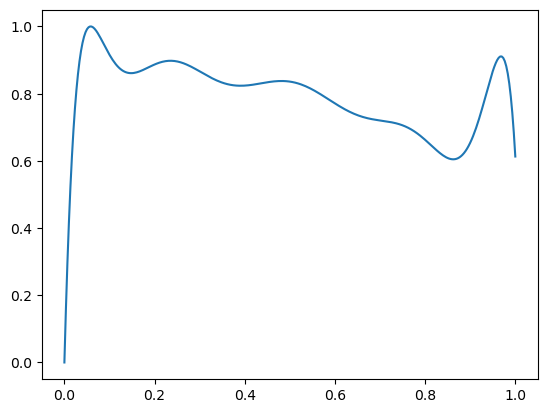

In [43]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(bins[:-1].view(-1, 1))

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, (hist + 1).log())
print(lin_reg.intercept_ , lin_reg.coef_)

tmp = lin_reg.predict(poly_features.transform(torch.linspace(0, 1, 300).view(-1, 1)))
tmp_min = tmp.min()
tmp = tmp - tmp_min
tmp_max = tmp.max()
tmp = tmp / tmp_max

plt.plot(torch.linspace(0, 1, 300).view(-1, 1), 1 - tmp)

In [42]:
tmp=lin_reg.predict(poly_features.transform(torch.linspace(0, 1, 300).view(-1, 1)))
print(tmp.min())

10.455187253415005


In [7]:
x = manager.training_data.data
a = lambda x: x.mean() * (x.mean() * (1 - x.mean()) / x.var() - 1)
b = lambda x: (1 - x.mean()) * (x.mean() * (1 - x.mean()) / x.var() - 1)

d = torch.distributions.Beta(a(x), b(x))

tmp_x_t = torch.linspace(0.1, 0.9, 300)
tmp_y_t = d.log_prob(tmp_x_t).exp()

from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly_features.fit_transform(tmp_x_t.view(-1, 1))

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, tmp_y_t)
print(lin_reg.intercept_ , lin_reg.coef_)

2.949126300615377 [   -41.38113808    360.27798413  -2000.64158484   7413.00407081
 -18719.27768754  32314.75408603 -37506.95034997  27978.80577345
 -12115.46023769   2315.16923661]


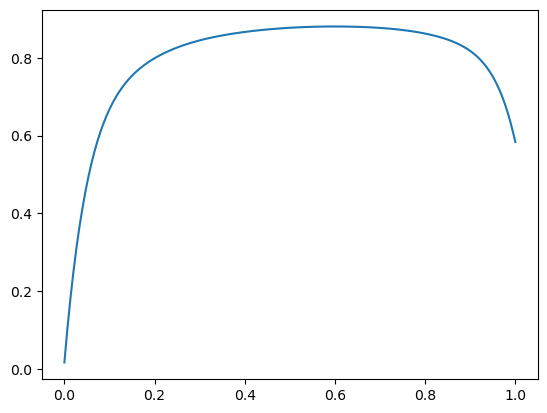

In [37]:
plt.plot(torch.linspace(0, 1, 300).view(-1, 1), 1 - lin_reg.predict(poly_features.transform(torch.linspace(0, 1, 300).view(-1, 1))) / 3)

[351.  11.   2.   6.   4.   0.   3.   1.   0.   0.   1.   0.   2.   1.
   0.   1.   0.   0.   1.   0.   0.   0.   0.   2.   0.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   1.   1.
   0.   0.   2.   0.   0.   0.   1.   0.   0.   0.   1.   0.   1.   1.
   1.   1.   1.   0.   0.   1.   2.   0.   1.   1.   2.   1.   0.   1.
   0.   0.   2.   2.   1.   1.   0.   2.   0.   0.   1.   0.   1.   0.
   0.   0.   0.   0.   1.   0.   0.   0.   2.   0.   0.   0.   0.   0.
   1.   2.   0.   0.   1.   0.   0.   0.   1.   2.   0.   1.   0.   0.
   0.   0.   0.   1.   0.   1.   0.   1.   0.   1.   2.   2.   0.   0.
   0.   3.   0.   0.   1.   0.   0.   0.   1.   0.   1.   0.   0.   0.
   0.   1.   0.   0.   1.   1.   1.   0.   0.   0.   1.   0.   0.   0.
   1.   1.   2.   0.   0.   2.   0.   1.   0.   1.   1.   0.   1.   2.
   2.   1.   1.   1.   3.   1.   0.   2.   4.   2.   1.   2.   1.   4.
   2.   3.   0.   3.   1.   1.   6.   3.   1.   5.   4.   6.   5.   2.
   3. 

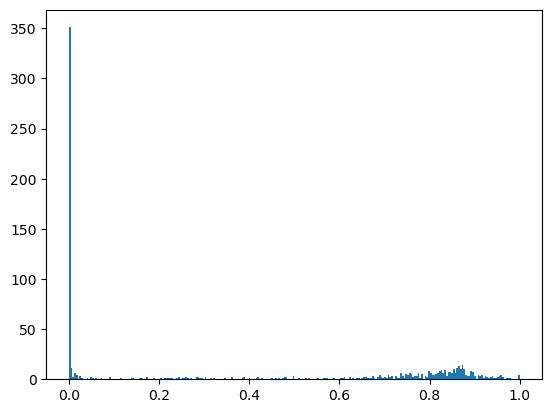

In [27]:
h, b, _ = plt.hist(manager.training_data.data[0].view(-1), bins=256)
print(h)

In [36]:
print(b)

[0.         0.00390625 0.0078125  0.01171875 0.015625   0.01953125
 0.0234375  0.02734375 0.03125    0.03515625 0.0390625  0.04296875
 0.046875   0.05078125 0.0546875  0.05859375 0.0625     0.06640625
 0.0703125  0.07421875 0.078125   0.08203125 0.0859375  0.08984375
 0.09375    0.09765625 0.1015625  0.10546875 0.109375   0.11328125
 0.1171875  0.12109375 0.125      0.12890625 0.1328125  0.13671875
 0.140625   0.14453125 0.1484375  0.15234375 0.15625    0.16015625
 0.1640625  0.16796875 0.171875   0.17578125 0.1796875  0.18359375
 0.1875     0.19140625 0.1953125  0.19921875 0.203125   0.20703125
 0.2109375  0.21484375 0.21875    0.22265625 0.2265625  0.23046875
 0.234375   0.23828125 0.2421875  0.24609375 0.25       0.25390625
 0.2578125  0.26171875 0.265625   0.26953125 0.2734375  0.27734375
 0.28125    0.28515625 0.2890625  0.29296875 0.296875   0.30078125
 0.3046875  0.30859375 0.3125     0.31640625 0.3203125  0.32421875
 0.328125   0.33203125 0.3359375  0.33984375 0.34375    0.3476

In [44]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)

    pe = torch.zeros_like(pred)
    p = 1
    for c in lin_reg.coef_:
        pe += c * pred**p
        p += 1
    pe += lin_reg.intercept_
    pe = (1.0 - (pe - tmp_min) / tmp_max).sum() / len(x)
    loss = ll + kl + pe
    return loss

manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=30)
name = 'pe 30'
manager.add_model(name)

Now, it is working on cuda:1.


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [03:37<00:00,  7.25s/it]


In [19]:
def compare_with_vanilla(manager, name, original_name='vanilla 30'):
    fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

    manager.swap_current_model(original_name)
    manager.model.to('cpu')
    manager.model.eval()

    for x, y in manager.train_dataloader:
        with torch.no_grad():
            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        
        with torch.no_grad():
            manager.swap_current_model(name)

            manager.model.to('cpu')
            manager.model.eval()

            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        
        break
    plt.tight_layout()

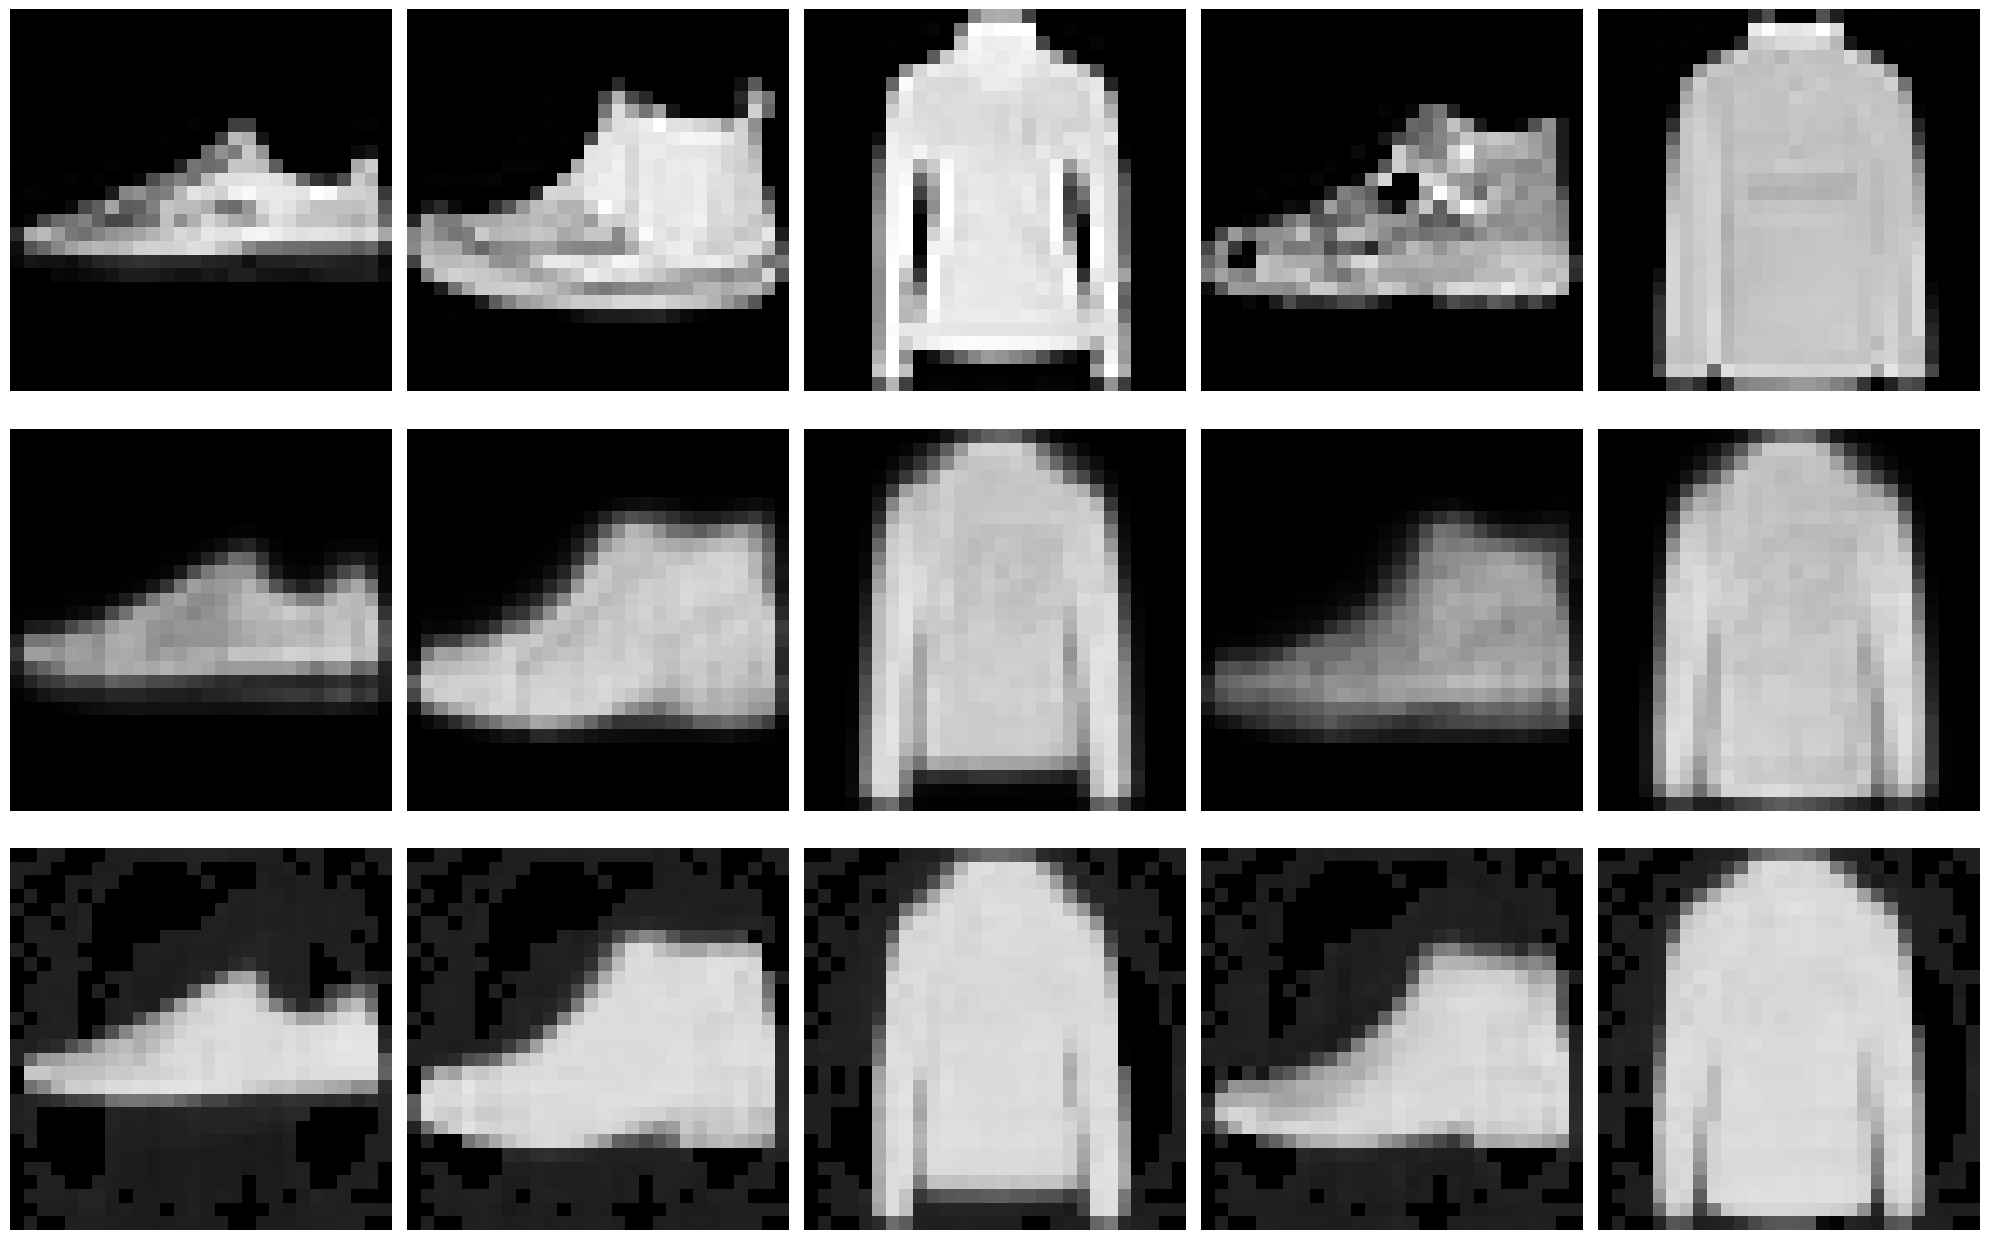

In [48]:
compare_with_vanilla(manager, 'pe 30')